In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import(
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    top_k_accuracy_score,
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
#For Detecting Class Imbalance
from sklearn.preprocessing import(
    LabelEncoder, 
    StandardScaler,
    OneHotEncoder
)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

#Hyperparameter tuning, data leakage prevention and data sampling techniques
from sklearn.pipeline import Pipeline

#Model candidates
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#fucking cleaning
import warnings
warnings.filterwarnings("ignore")

#Model Export
import joblib

In [22]:
df = pd.read_csv("ad_click_dataset.csv")
df = df.drop(columns=["id", "full_name"])
df

,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,NaN,Male,Desktop,Top,NaN,NaN,1
2,41.0,Non-Binary,NaN,Side,Education,Night,1
3,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...
9995,NaN,NaN,Mobile,Top,Education,NaN,0
9996,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,NaN,Male,Mobile,Side,NaN,Morning,0
9998,NaN,NaN,Desktop,NaN,Shopping,Morning,1


In [4]:
df.isnull().sum()
#Ok, Thers is a need to do label encoding and more im cooked (before data visualization)

id                     0
full_name              0
age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

In [26]:
#data cleaning & imputation before data visualization
imputer = SimpleImputer(strategy="median")
encoder = LabelEncoder()

#data cleaning and imputed values
df["age"] = imputer.fit_transform(df[["age"]]).astype("int")
df["gender"] = encoder.fit_transform(df[["gender"]])
df["device_type"] = encoder.fit_transform(df[["device_type"]])
df["ad_position"] = encoder.fit_transform(df[["ad_position"]])
df["browsing_history"] = encoder.fit_transform(df[["browsing_history"]])
df["time_of_day"] = encoder.fit_transform(df[["time_of_day"]])
df

,age,gender,device_type,ad_position,browsing_history,time_of_day,click,age_squared,age_cubed,age_adpos,gender_ctr,inv_adpos,log_adpos
0,22,3,0,2,3,0,1,484.00,10648.000,44.0,0.650117,0.500000,1.098612
1,39,1,0,2,5,4,1,1560.25,61629.875,79.0,0.658011,0.500000,1.098612
2,41,2,3,1,0,3,1,1681.00,68921.000,41.0,0.632592,1.000000,0.693147
3,34,1,3,3,1,1,1,1156.00,39304.000,102.0,0.658011,0.333333,1.386294
4,39,2,3,3,4,2,0,1521.00,59319.000,117.0,0.632592,0.333333,1.386294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,39,3,1,2,0,4,0,1560.25,61629.875,79.0,0.650117,0.500000,1.098612
9996,39,0,0,0,1,4,0,1560.25,61629.875,0.0,0.657579,inf,0.000000
9997,39,1,1,1,5,2,0,1560.25,61629.875,39.5,0.658011,1.000000,0.693147
9998,39,3,0,3,3,2,1,1560.25,61629.875,118.5,0.650117,0.333333,1.386294


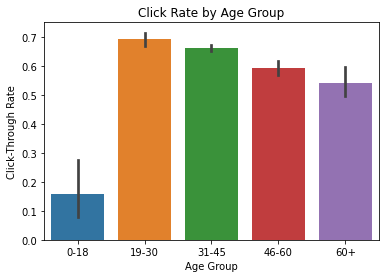

In [35]:
#data visualization
# Bin age
df['age_bin'] = pd.cut(df['age'], bins=[0, 18, 30, 45, 60, 100], labels=['0-18', '19-30', '31-45', '46-60', '60+'])

# Plot click rate by age bin
sns.barplot(data=df, x='age_bin', y='click', estimator=lambda x: sum(x)/len(x))
plt.title("Click Rate by Age Group")
plt.ylabel("Click-Through Rate")
plt.xlabel("Age Group")
#plt.savefig("Click Rate by Age Group.png")
plt.show()

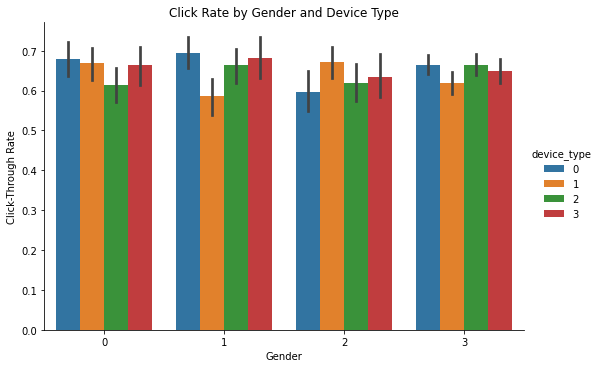

In [36]:
sns.catplot(data=df, x='gender', hue='device_type', y='click', kind='bar', height=5, aspect=1.5)
plt.title("Click Rate by Gender and Device Type")
plt.ylabel("Click-Through Rate")
plt.xlabel("Gender")
#plt.savefig("Click Rate by Gender and Device Type.png")
plt.show()

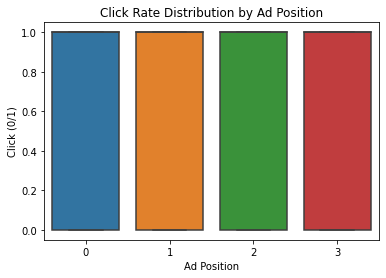

In [38]:
sns.boxplot(data=df, x='ad_position', y='click')
plt.title("Click Rate Distribution by Ad Position")
plt.ylabel("Click (0/1)")
plt.xlabel("Ad Position")
#plt.savefig("Click Rate Distribution by Ad Position.png")
plt.show()

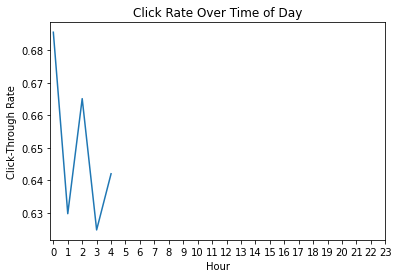

In [39]:
df['hour'] = df['time_of_day']
df['sin_time'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_time'] = np.cos(2 * np.pi * df['hour'] / 24)

# Plot click rate over hour of day
hourly_click_rate = df.groupby('hour')['click'].mean().reset_index()
sns.lineplot(data=hourly_click_rate, x='hour', y='click')
plt.xticks(range(0, 24))
plt.title("Click Rate Over Time of Day")
plt.ylabel("Click-Through Rate")
plt.xlabel("Hour")
#plt.savefig("Click Rate Over Time of Day.png")
plt.show()

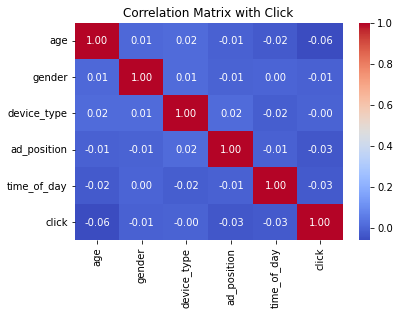

In [40]:
df_encoded = pd.get_dummies(df[['age', 'gender', 'device_type', 'ad_position', 'time_of_day']], drop_first=True)
df_encoded['click'] = df['click']

sns.heatmap(df_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix with Click")
#plt.savefig("Correlation Matrix with Click.png")
plt.show()

In [12]:
fig = px.sunburst(df, path=['gender', 'device_type', 'ad_position'], values='click', color='click',
                  color_continuous_scale='RdBu', title='Click Distribution Across Categories')

# Save to interactive HTML
pio.write_html(fig, file='sunburst_chart.html', auto_open=False)

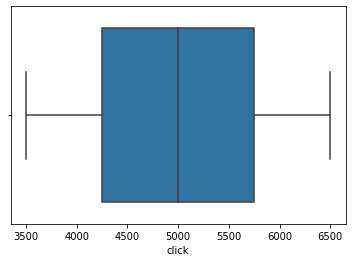

In [20]:
#Detecting Class Imbalance
imbalance_counts = df["click"].value_counts()
sns.boxplot(imbalance_counts)
#plt.savefig("Class Imbalance.png")
plt.show()

In [38]:
#Feature Engineering for the dataset
def EngineerFeatures(df):
    # Polynomial age features
    df['age_squared'] = df['age'] ** 2
    df['age_cubed'] = df['age'] ** 3
    df['age_adpos'] = df['age'] * df['ad_position']
    
    # Target encoding by gender
    df['gender_ctr'] = df.groupby('gender')['click'].transform('mean')
    
    # Ad position transforms
    df['inv_adpos'] = 1 / (df['ad_position'] + 1e-6)  # avoid divide by zero
    df['log_adpos'] = np.log1p(df['ad_position'])

    # Cross feature: gender × device_type (numerical ID)
    df['gender_device_encoded'] = (df['gender'] * 10) + df['device_type']  # example: 1×10 + 0 = 10

    # Cross feature: age_group × device_type (fully numeric)
    df['age_group'] = pd.cut(
        df['age'], bins=[0, 18, 30, 45, 60, 100], labels=False
    )
    df['age_group_device_encoded'] = (df['age_group'] * 10) + df['device_type']

    # Rolling CTR (time-ordered)
    df['rolling_ctr_3'] = df['click'].rolling(window=3, min_periods=1).mean()

    # Lag features
    df['prev_click'] = df['click'].shift(1)
    df['time_since_last_click'] = df['time_of_day'].diff().fillna(0)
    df['lag_1_click'] = df['click'].shift(1)
    df['lag_2_adpos'] = df['ad_position'].shift(2)

    # Rank within device
    df['rank_in_device'] = df.groupby('device_type')['ad_position'].rank()

    # Browsing history entropy
    def compute_bh_entropy(browsing_str):
        if pd.isnull(browsing_str):
            return 0.0
        browsing_str = str(browsing_str)
        categories = browsing_str.split(',')
        value_counts = pd.Series(categories).value_counts(normalize=True)
        return scipy.stats.entropy(value_counts)

    df['bh_entropy'] = df['browsing_history'].apply(compute_bh_entropy)

    # Behavior score (all numeric)
    def behavior_score(row):
        entropy = row['bh_entropy']
        click_rate = row['gender_ctr']
        device_penalty = 1 if row['device_type'] == 1 else 0.5
        return entropy * click_rate * device_penalty

    df['behavior_score'] = df.apply(behavior_score, axis=1)

    # Cumulative clicks
    df['cum_clicks_by_device'] = df.groupby('device_type')['click'].cumsum()

    # Remove any remaining strings just in case
    df = df.select_dtypes(exclude=['object'])

    # Final clean-up
    df = df.fillna(0)

    return df

In [70]:
#Model Building and Evaluation
df = EngineerFeatures(df)
X = df.drop("click", axis=1)
y = df["click"]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1))
])

scores = cross_val_score(pipe, X, y, cv=5, scoring='f1')  # or 'accuracy', 'roc_auc', etc.
print("Cross-validated F1 scores for LogisticRegression:", scores)
print("Mean F1 score:", scores.mean())

Cross-validated F1 scores for LogisticRegression: [0.78504673 0.77762106 0.79238272 0.7839102  0.78787879]
Mean F1 score: 0.7853678995217936


In [71]:
#For Random Forest Classifier to see which is the best model to use
pipe_2 = Pipeline([
    ("scaler", StandardScaler()), 
    ("model", RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', bootstrap=True, class_weight='balanced', random_state=42, n_jobs=-1))
])

scores_2 = cross_val_score(pipe_2, X, y, cv=5, scoring='f1')  # or 'accuracy', 'roc_auc', etc.
print("Cross-validated F1 scores for RandomForestClassifier:", scores_2)
print("Mean F1 score:", scores_2.mean())

Cross-validated F1 scores for RandomForestClassifier: [0.82599401 0.82202305 0.83206107 0.82761615 0.8365019 ]
Mean F1 score: 0.8288392369196755


In [79]:
#Ok, we are using the 1st model
pipe.fit(X_train, Y_train)

y_pred = pipe.predict(X_test)

In [47]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("F1 Score:       ", f1_score(y_test, y_pred))
    print("Precision:      ", precision_score(y_test, y_pred))
    print("Recall:         ", recall_score(y_test, y_pred))
    print("ROC AUC:        ", roc_auc_score(y_test, y_proba))
    print("Top-1 Accuracy: ", top_k_accuracy_score(y_test, y_proba.reshape(-1, 1), k=1))

In [80]:
#Model Test Results
evaluate_model(pipe, X_test, Y_test)

F1 Score:        0.790134946486738
Precision:       1.0
Recall:          0.6530769230769231
ROC AUC:         0.8935043956043955
Top-1 Accuracy:  0.7745


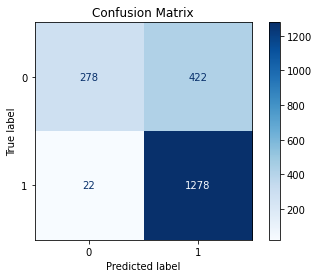

In [81]:
y_proba = pipe.predict_proba(X_test)[:, 1]
y_pred = pipe.predict(X_test)
y_pred_custom = (y_proba >= 0.3).astype(int) 

cm = confusion_matrix(Y_test, y_pred_custom)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'd' for integer formatting

plt.title("Confusion Matrix")
plt.savefig("Confusion Matrix.png")
plt.show()

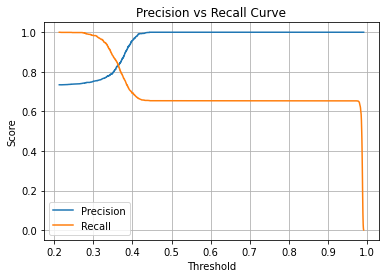

In [82]:
prec, rec, thresholds = precision_recall_curve(Y_test, y_proba)
plt.plot(thresholds, prec[:-1], label='Precision')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall Curve')
plt.legend()
plt.grid()
plt.savefig("Precision vs Recall Curve.png")
plt.show()

In [83]:
prec, rec, thresholds = precision_recall_curve(Y_test, y_proba)
f1 = 2 * (prec * rec) / (prec + rec + 1e-6)
best_thresh = thresholds[np.argmax(f1)]
best_f1 = np.max(f1)

print("Best threshold for F1:", best_thresh)
print("Best F1 score:", best_f1)

Best threshold for F1: 0.30587831585261965
Best F1 score: 0.853706923488765


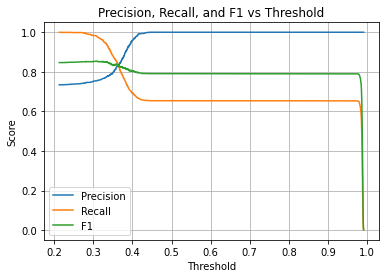

In [84]:
plt.plot(thresholds, prec[:-1], label='Precision')
plt.plot(thresholds, rec[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 vs Threshold')
plt.legend()
plt.grid()
plt.savefig("Precision, Recall, and F1 vs Threshold.png")
plt.show()

In [85]:
#Final Scoring for the model
# Predict using best threshold
y_pred_optimal = (y_proba >= 0.3058).astype(int)

# Evaluate again
print("Precision:", precision_score(Y_test, y_pred_optimal))
print("Recall:   ", recall_score(Y_test, y_pred_optimal))
print("F1 Score: ", f1_score(Y_test, y_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(Y_test, y_pred_optimal))

Precision: 0.7544273907910272
Recall:    0.9830769230769231
F1 Score:  0.8537074148296593
Confusion Matrix:
 [[ 284  416]
 [  22 1278]]


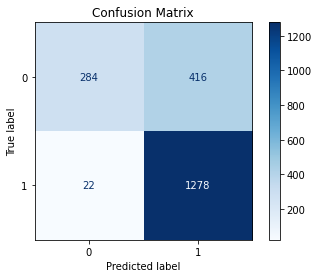

In [86]:
#Plotting the best classification model
cm = confusion_matrix(Y_test, y_pred_optimal)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')  # 'd' for integer formatting

plt.title("Confusion Matrix")
plt.savefig("Final Confusion Matrix.png")
plt.show()

In [87]:
#exporting the model for production ready use
joblib.dump(pipe, "final_model.pkl")
joblib.dump(0.3058, "best_threshold.pkl")

['best_threshold.pkl']